# Ex 2 - Transfer learning
##### Group: 11
###### Student 1:  Patrick Koller
###### Student 2:  Yohanes Sugiarto
###### Student 3:  Florian Merz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
CHECKPOINT_FILE_PREFIX = '/content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from sklearn.metrics import accuracy_score

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
from IPython.core.debugger import set_trace
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Load the Dataset and visualize it

In [ ]:
# Download and split the food101 dataset
(train_ds, validation_ds, test_ds), info = tfds.load(
    "food101",
    split=["train", "validation[:50%]", "validation[50%:]"],
    as_supervised=True,
    with_info=True
)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteU3MVO2/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteU3MVO2/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Filter the dataset to keep the first 20 classes only.
N_CLASSES = 20
CLASS_NAMES = info.features['label'].names[:N_CLASSES]

train_ds = train_ds.filter(lambda img, label: label < N_CLASSES)
validation_ds = validation_ds.filter(lambda img, label: label < N_CLASSES)
test_ds = test_ds.filter(lambda img, label: label < N_CLASSES)

In [ ]:
# This step takes too much time. It is not madatory to execute it.
print("Training samples: %d" % train_ds.reduce(0, lambda x,_: x+1).numpy())
print("Validation samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())
print("Tests samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())

Training samples: 15000
Validation samples: 2514
Tests samples: 2514


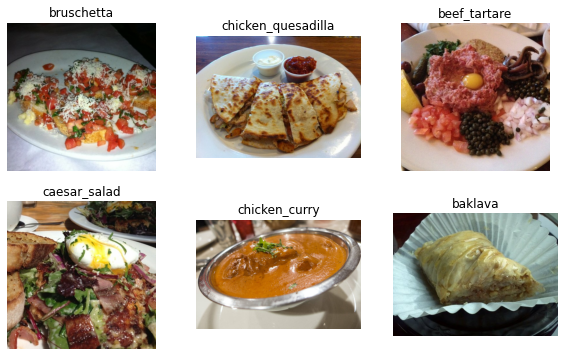

In [ ]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    plt.axis("off")

## Resize and normalize

In [ ]:
def print_shape(msg): 
  for img,_ in train_ds.take(1): print(msg, img.shape)

def print_sample(msg): 
  for img,_ in train_ds.take(1): print(msg, img[0,0,:])

def print_label(msg): 
  for _,label in train_ds.take(1): print(msg, label)

In [ ]:
# TODO Resize the images in the training, validation and test set
def img_resize(img, label):
  img = tf.image.resize(img, [160, 160])
  return img, label

print_shape("OLD Shape:")

train_ds = train_ds.map(img_resize)
validation_ds = validation_ds.map(img_resize)
test_ds = test_ds.map(img_resize)

print_shape("NEW Shape:")

OLD Shape: (512, 512, 3)
NEW Shape: (160, 160, 3)


In [ ]:
# Normalize the images
def img_normalize(img, label):
  img = tf.keras.applications.mobilenet.preprocess_input(img)
  return img, label

print_sample("OLD Sample:")

train_ds = train_ds.map(img_normalize)
validation_ds = validation_ds.map(img_normalize)
test_ds = test_ds.map(img_normalize)

print_sample("NEW Sample:")

OLD Sample: tf.Tensor([11.9 11.9 11.9], shape=(3,), dtype=float32)
NEW Sample: tf.Tensor([-0.90666664 -0.90666664 -0.90666664], shape=(3,), dtype=float32)


In [ ]:
# One hot encode the labels
def label_one_hot(img, label):
  label = tf.one_hot(label, N_CLASSES)
  return img, label

print_label("OLD Label:")

train_ds = train_ds.map(label_one_hot)
validation_ds = validation_ds.map(label_one_hot)
test_ds = test_ds.map(label_one_hot)

print_label("NEW Label:")

OLD Label: tf.Tensor(10, shape=(), dtype=int64)
NEW Label: tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(20,), dtype=float32)


In [ ]:
# autotune prefetch buffer
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Data-Augmentation

In [ ]:
# Optional define/implements data-augmentation
data_augmentation = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  keras.layers.experimental.preprocessing.RandomContrast(0.1),
  keras.layers.experimental.preprocessing.RandomZoom(0.1),
  keras.layers.experimental.preprocessing.RandomHeight(0.1),
  keras.layers.experimental.preprocessing.RandomWidth(0.1),
  keras.layers.experimental.preprocessing.RandomRotation(0.1),
  keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])

## Training
### Step 1: Only train the head of the network

In [ ]:
%%time
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models. 
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours. 
# A model like mobilenet is more than enough for the exercise.

base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(160, 160, 3))

# Freeze the base_model
base_model.trainable = False

# Create the model structure
model = tf.keras.Sequential([
  keras.layers.Input((160, 160, 3)),
  data_augmentation,
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1024),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(N_CLASSES, activation='softmax')
])

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________

In [ ]:
%%time

CHECKPOINT_FILE_FREEZE = CHECKPOINT_FILE_PREFIX + "_freeze.h5" 
EPOCHS = 1000
BATCH_SIZE = 32

# Compile the model with your optimizer, your loss and your metrics
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'])

# Optional: Define and use callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    CHECKPOINT_FILE_FREEZE,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=1,
    verbose=1
)

 # You should us a relatively big learning rate: 1e-3
step1_history = model.fit(
    train_ds.batch(BATCH_SIZE),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_ds.batch(BATCH_SIZE),
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/1000
30/30 [==============================] - 346s 11s/step - loss: 1.2999 - accuracy: 0.5993 - val_loss: 1.1610 - val_accuracy: 0.6372

Epoch 00001: val_accuracy improved from -inf to 0.63723, saving model to /content/drive/MyDrive/TSM_DeLearn/ex9/ex2_checkpoint.h5
Epoch 2/1000
 1/30 [>.............................] - ETA: 7:50 - loss: 1.1541 - accuracy: 0.6523

KeyboardInterrupt: ignored

In [ ]:
# reload best weights
model.load_weights(CHECKPOINT_FILE_FREEZE)

In [ ]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(step1_history, 'loss')

### Step 2: Fine-Tune the whole model

In [ ]:
%%time

CHECKPOINT_FILE_FINETUNING = CHECKPOINT_FILE_PREFIX + "_finetuning.h5
EPOCHS = 1000
BATCH_SIZE = 32

# Unfreeze the pretrained base. 
base_model.trainable = True


# Compile the model again
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy'])


# Retrain the model
# Optional: Define and use callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    CHECKPOINT_FILE_FINETUNING,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=1,
    verbose=1
)

 # You should us a small learning rate: for example 1e-5 or 1e-6
step2_history = model.fit(
    train_ds.batch(BATCH_SIZE),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_ds.batch(BATCH_SIZE),
    callbacks=[model_checkpoint, early_stopping]
)

In [ ]:
# reload best weights
model.load_weights(CHECKPOINT_FILE_FINETUNING)

In [ ]:
plot_history(step2_history, 'loss')

## Test the fine-tuned model

In [ ]:
%%time
# Predict the test set
y_pred = model.predict(test_ds, verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

In [ ]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

In [ ]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds])+1)/2*255
    test_examples = test_examples.astype("uint32")
    
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)